In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d hasyimabdillah/workoutexercises-images

Dataset URL: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images
License(s): CC-BY-NC-SA-4.0
 99% 809M/818M [00:15<00:00, 79.3MB/s]
100% 818M/818M [00:15<00:00, 56.2MB/s]


In [ ]:
!unzip /content/workoutexercises-images.zip -d /content/workoutexercises-images && rm /content/workoutexercises-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/workoutexercises-images/pull up/pull up_700211.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_700221.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_700231.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_700241.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_700251.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_700261.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800001.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800011.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800021.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800031.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800041.jpg  
  inflating: /content/workoutexercises-images/pull up/pull up_800051.jpg  
  inflating: /content/workoutexercises-images/pul

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 256
img_shape = (height, width, channels)
img_size = (height, width)

In [ ]:
DATA_DIR = '/content/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = False,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

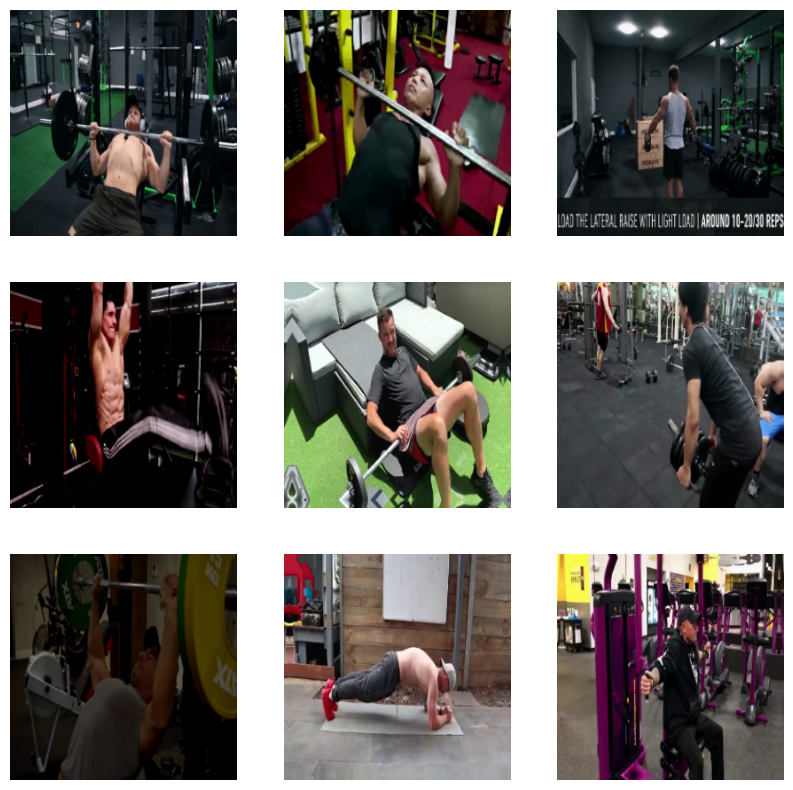

In [ ]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [ ]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input,
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'auto',
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100
49/49 [==============================] - 202s 3s/step - loss: 2.3252 - accuracy: 0.3223 - val_loss: 2.5545 - val_accuracy: 0.5415
Epoch 2/100
49/49 [==============================] - 160s 3s/step - loss: 1.5462 - accuracy: 0.5500 - val_loss: 1.5366 - val_accuracy: 0.6238
Epoch 3/100
49/49 [==============================] - 162s 3s/step - loss: 1.1715 - accuracy: 0.6575 - val_loss: 1.2871 - val_accuracy: 0.6765
Epoch 4/100
49/49 [==============================] - 164s 3s/step - loss: 0.9594 - accuracy: 0.7256 - val_loss: 0.7634 - val_accuracy: 0.7906
Epoch 5/100
49/49 [==============================] - 161s 3s/step - loss: 0.8045 - accuracy: 0.7684 - val_loss: 0.5794 - val_accuracy: 0.8484
Epoch 6/100
49/49 [==============================] - 161s 3s/step - loss: 0.7338 - accuracy: 0.7934 - val_loss: 0.5276 - val_accuracy: 0.8650
Epoch 7/100
49/49 [==============================] - 158s 3s/step - loss: 0.6408 - accuracy: 0.8130 - val_loss: 0.5050 - val_accuracy: 0.8765
Epoch 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-fa1ec22588f5>", line 7, in <cell line: 7>
    history = workout_model.fit(train_ds,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorph

TypeError: object of type 'NoneType' has no len()

In [ ]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

6/6 [==============================] - 7s 1s/step - loss: 0.1152 - accuracy: 0.9690


NameError: name 'history' is not defined